# Autoencoders

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


## Generative models

ML model สามารถแบ่งตามวัตถุประสงค์การใช้งานได้ดังนี้
- <b>Discriminative model</b> เป็น model ที่พยายามจำแนกข้อมูล
- <b>Generative model</b> เป็น model ที่พยายามเรียนรู้ distribution ของข้อมูลเดิม และสร้างข้อมูลใหม่ที่คล้ายเดิม มี loss เป็นความต่าง (divergence) ระหว่าง true data distribution ($p(x)$) กับ generated data distribution ($\hat{p}(x)$) 

<img src="../images/generative_model.png" width="500" /><br />

- <b>Reinforcement model</b> เป็น model ที่พยายามเรียนรู้การตอบสนองต่อสิ่งแวดล้อม

## Autoencoders

An Autoencoder is a "Deep Generative Model" where an observed variable is transformed to a lower dimensional space known as a latent space using an <b>enconder</b> neural network, and the latent space is transformed back to the observed variable space using a <b>decoder</b> neural network.

### Architectures

<img src="../images/autoencoder.png" width="500" /><br />

- $\boldsymbol{T}$ = vector/matrix of latent variables
- Latent space คือค่า latent variable ทั้งหมดที่เป็นไปได้
- $\boldsymbol{y}$ = vector/matrix of data/images
- $\sigma$ = non-linear node

### Training autoencoders

ก่อน train autoencoder ภาพ input $x$ ถูกส่งเข้าไปใน encoder $\phi$ ได้ random latent vector $x_i$ ใน latent space $z = \phi(x)$ ซึ่งถูกส่งเข้าไปใน decoder $\theta$ ได้ภาพ output $\hat{x} = \theta(z)$ ออกมา เป็น random noise

การเทรน autoencoder ถือว่าเป็น unsupervised training เพราะไม่มี label

Loss function หาได้โดยเทียบ output กับ input และปรับค่า weight ที่อยู่ใน encoder กับ decoder เพื่อทำให้ loss น้อยลง

<img src="../images/training_autoencoder.png" /><br />

In [4]:
# Download the training MNIST dataset and create a data loader for it
data = DataLoader(
    MNIST('../data', train=True, download=True, transform=ToTensor()),
    batch_size=128,
    shuffle=True
)

In [5]:
# Create an encoder and a decoder to be used in an autoencoder
class Encoder(nn.Module):
    """Encoder with 2 fully-connected layers"""
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Linear(784, 512)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()

    def forward(self, x):
        '''
        Parameters
        ----------
        x : float

            Input image

        '''
        x = x.flatten(start_dim=1)  # Reshape the input into a vector (nD to 1D)
        x = self.activation1(self.layer1(x))
        x = self.activation2(self.layer2(x))
        return x

class Decoder(nn.Module):
    """Decoder with 2 fully-connected layers"""
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(256, 512)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 784)
        self.activation2 = nn.Sigmoid()

    def forward(self, z):
        '''
        Parameters
        ----------
        z : float

            Latent variable

        '''
        z = self.activation1(self.layer1(z))
        z = self.activation2(self.layer2(z))
        z = z.reshape((-1, 1, 28, 28))  # Reshape the vector into a (28x28) grayscale image
        return z

In [6]:
# Create an autoencoder
class Autoencoder(nn.Module):
    def __init__(self, dims_latent):
        '''
        Parameters
        ----------
        dims_latent : int

            The dimension of (the number of nodes in) the mean-field gaussian latent variable.

        '''
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.latentIn = nn.Linear(256, dims_latent)
        self.latentOut = nn.Linear(dims_latent, 256)
        self.activationOut = nn.ReLU()

    def forward(self, x):
        '''
        Parameters
        ----------
        x : float

            A batch of images from the data loader.

        '''
        x = self.encoder(x)
        z = self.latentIn(x)
        z = self.activationOut(self.latentOut(z))
        x_hat = self.decoder(z)
        return x_hat

In [7]:
# Define a function for training the autoencoder
def train(autoencoder, data, epochs=10):
    optimizer = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for batch, label in data:
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat = autoencoder(batch)
            loss = ((batch - x_hat)**2).sum()  # L2 loss
            loss.backward()
            optimizer.step()
    return autoencoder  # Return the trained autoencoder

In [8]:
# Define functions for plotting latent vectors
def plot_2D_latent_vectors(autoencoder, data, num_batches=100):
    '''Plot the latent vectors for images'''
    for n, (batch, label) in enumerate(data):
        batch = batch.to(device)
        z = autoencoder.latentIn(autoencoder.encoder(batch))  # Get latent vectors by passing the batch
                                                              # through the encoder and the latent input layer
        z = z.to('cpu').detach().numpy()  # Send to CPU
        # Plot latent vectors and colour them by labels
        plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10')
        if n > num_batches:  # stop after n > maximum number of batches
            plt.colorbar()
            break

def plot_2D_single_latent_vector(autoencoder, image):
    '''Plot the latent vector for a single image'''
    image = image.to(device)
    z = autoencoder.latentIn(autoencoder.encoder(image))  # Get the latent vector by passing the image
                                                          # through the encoder and the latent input layer
    z = z.to('cpu').detach().numpy()  # Send to CPU
    plt.scatter(z[:, 0], z[:, 1], marker='x', c='k')  # Plot the latent vector

In [9]:
# Define a function to plot an image generated by an autoencoder given a latent vector (z)
def plot_output(autoencoder, z):
    z_out = autoencoder.activationOut(autoencoder.latentOut(z))
    img = autoencoder.decoder(z_out).to('cpu').detach().numpy()[0, 0]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img)

In [10]:
# Initialise an autoencoder
autoencoder = Autoencoder(dims_latent=2).to(device)

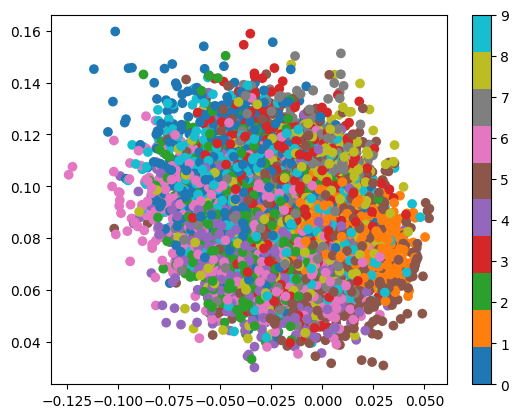

In [11]:
# Plot latent vactors produced by the untrained autoencoder
plot_2D_latent_vectors(autoencoder, data)

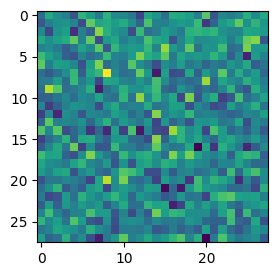

In [12]:
# Plot an output image generated by the untrained autoencoder given a latent vector z
# From the latent space plotted above, we cannot find the label of the image
# generated by the untrained autoencoder given a latent vector of (0, 0)
z = torch.tensor([0, 0]).to(device).float()
plot_output(autoencoder, z)

In [13]:
# Train the autoencoder
autoencoder = train(autoencoder, data, 10)

KeyboardInterrupt: 

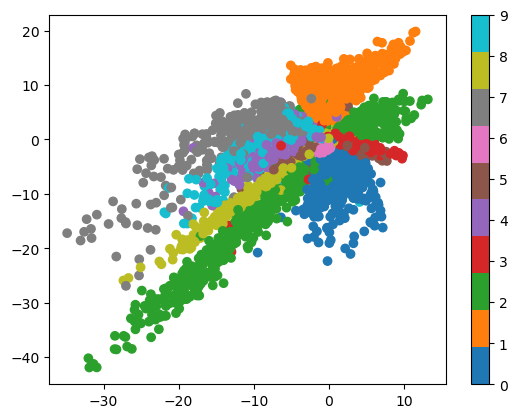

In [58]:
# Plot latent vactors produced by the trained autoencoder
plot_2D_latent_vectors(autoencoder, data)

In [59]:
# Get the next iteration from the data loader
batch, labels = next(iter(data))

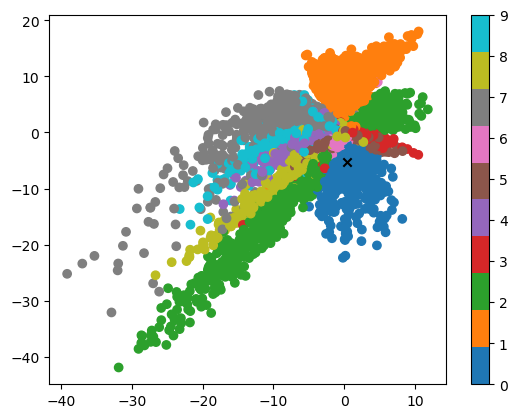

In [60]:
# Plot latent vactors produced by the trained autoencoder
# and the latent vector for the first image in the batch
image = batch[0]
plt.figure()
plot_2D_latent_vectors(autoencoder, data)
plot_2D_single_latent_vector(autoencoder, image)

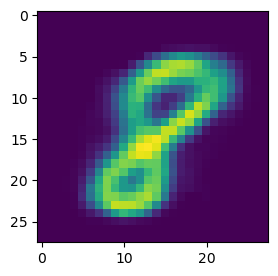

In [65]:
# Plot an output image generated by the trained autoencoder given a latent vector z
# We can see from the latent space plotted above that
# a latent vector of (-10, -10) will give an image with a label of 8
z = torch.tensor([-10, -10]).to(device).float()
plot_output(autoencoder, z)